# Analysis 2
- Outcome: NCGC in 5 years
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
source("utils.R")
library(survival)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
model = 'logreg'
cancer = 'NCGC'
ro.globalenv['cancer'] = cancer

analysis_num = '2'

In [8]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), "_5yr")

In [9]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
model_filename = f'{model}_{cancer}.rds'

In [10]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)
ro.globalenv['model_filename'] = model_filename

## Univariate analysis - logistic regression

### Factorize categorical vars and set reference levels

In [11]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [12]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [13]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    # Build formula
    model <- train_logreg_model(train_set = r_df_normal, selected_vars = var, outcome = outcome_event)

    # Get model summary in formatted dataframe 
    model_df <- get_logreg_univariate_summary(model, var, categorical_vars)
    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [14]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [15]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex_missing.(Intercept),sex_missing,(Intercept),0.000028,0.000018,0.000040,0.000000e+00
1,sex_missing.sex_missingMALE,sex_missing,MALE,2.180532,1.367970,3.557585,1.313882e-03
2,race_clean.(Intercept),race_clean,(Intercept),0.000035,0.000023,0.000052,0.000000e+00
3,race_clean.race_cleanAsian,race_clean,Asian,2.838467,1.244135,5.930835,7.970855e-03
4,race_clean.race_cleanBlack or African American,race_clean,Black or African American,2.544504,1.371159,4.666327,2.591529e-03
7,ethnicity.(Intercept),ethnicity,(Intercept),0.000056,0.000042,0.000073,0.000000e+00
9,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.138258,0.048056,0.314424,2.458559e-05
10,alcohol_binary.(Intercept),alcohol_binary,(Intercept),0.000045,0.000034,0.000057,0.000000e+00
12,tobacco_binary.(Intercept),tobacco_binary,(Intercept),0.000040,0.000031,0.000052,0.000000e+00
14,hpylori_active_chronic_binary.(Intercept),hpylori_active_chronic_binary,(Intercept),0.000043,0.000034,0.000053,0.000000e+00


## Feature selection

In [16]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"  "race_clean"   "ethnicity"    "hnca"         "pud"         
 [6] "gerd"         "cad"          "famhx_cancer" "PPI"          "age"         


### Forest plot for univariate visualization

In [17]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

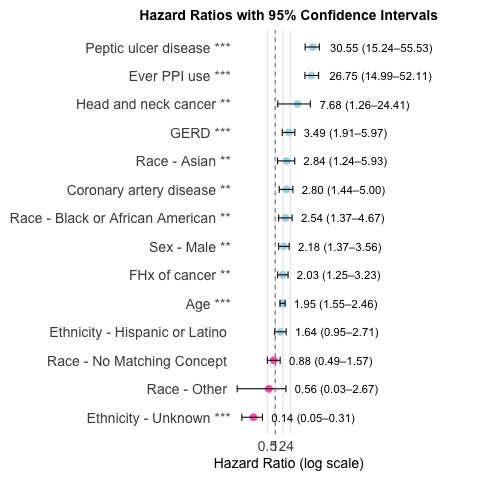

In [18]:
%%R 
plot_univariate_forest(forestplot_df)

## Logistic regression multivariate model training

#### Split dataset into training and validation

In [19]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_logreg_model(train_set, selected_vars, outcome_event, model_func=glm)

[1] "Dataset Controls 34108" "Dataset Cases 75"      
[1] "Training Controls 27285" "Training Cases 62"      
[1] "Validation Controls 6823" "Validation Cases 13"     



#### Multivariate analysis

In [20]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_logreg_results(logreg_model, multivariate_filename)

Multivariate results saved to ./../results/multivariate_analysis_2_NCGC.csv 


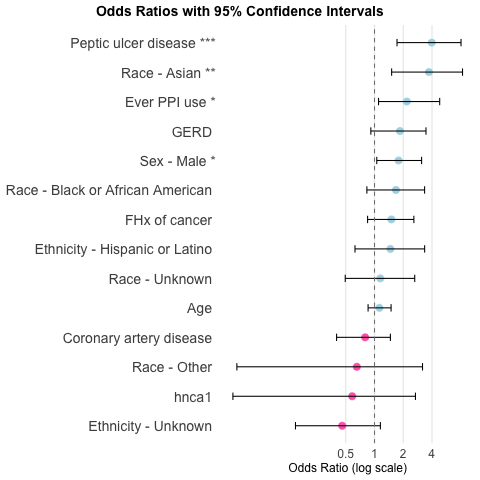

In [21]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [22]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
event_5_years <- r_df_validation_risk[[outcome_event]]

# Get the predicted risk 
risk_5_years <- calculate_risk_from_logreg(logreg_model, validation_set)
r_df_validation_risk$pred_risk <- risk_5_years

In [23]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


In [24]:
%%R 
# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.783 
Sensitivity: 0.6923077 
Specificity: 0.7007182 
PPV: 0.004388103 
NPV: 0.9991641 
NNS: 281.519 
     predicted_class
event    0    1
    0 4781 2042
    1    4    9


### Sensitivity and Metrics at threshold that maximizes Youdens

In [25]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.783 
Sensitivity: 0.9230769 
Specificity: 0.592408 
PPV: 0.004296455 
NPV: 0.9997527 
NNS: 246.9676 
     predicted_class
event    0    1
    0 4042 2781
    1    1   12


### AUROC curves and PR curve

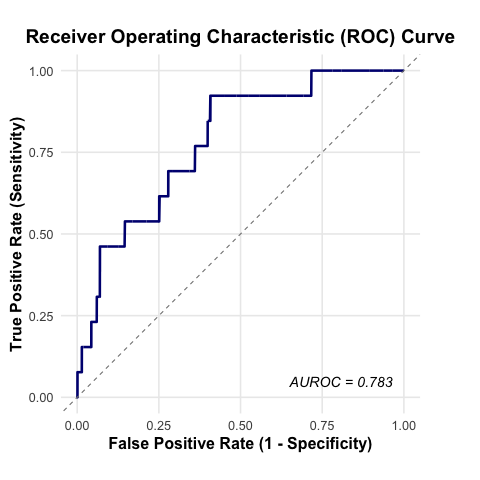

In [26]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

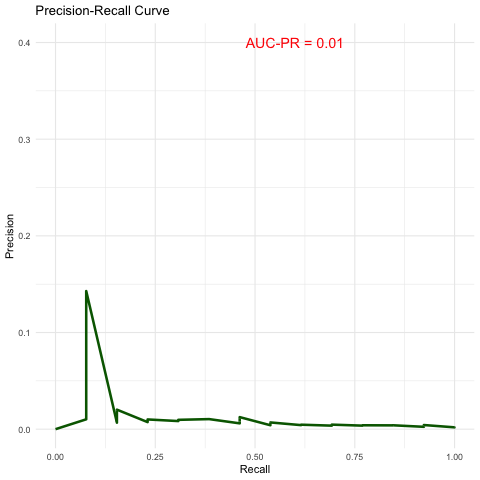

In [27]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [28]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [29]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,pred_risk,actual_percentile,risk_group,risk_p0.5,risk_p0.5914277355178467,risk_p0.6,risk_p0.7,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001302,0.404915,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001197,0.371123,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003365,0.826653,0.80,1,1,1,1,1,1,0,0,0,0,0,0,0,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002372,0.694412,0.60,1,1,1,0,0,0,0,0,0,0,0,0,0,1
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003597,0.851521,0.85,1,1,1,1,1,1,1,0,0,0,0,0,0,1


In [30]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events_5yr = ['ugica_5yr', 'escc_5yr', 'eac_5yr', 'cgc_5yr', 'ncgc_5yr']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events_5yr: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", 'ugica_5yr', race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", 'ugica_5yr', sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", 'ugica_5yr', age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", 'ugica_5yr', visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [31]:
df_results.tail()

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,ugica_5yr,70-79,1953,7,851,6 (0.7%),0.7,6,845,1,1108,0.568367,0.431633,85.714286,56.733231,0.705053,99.909829,162.632948,0.424475
71,high_risk_youden,youden,ugica_5yr,50-59,1262,9,467,8 (1.7%),1.7,8,459,1,803,0.638080,0.361920,88.888889,63.629160,1.713062,99.875622,62.945180,0.525180
72,high_risk_youden,youden,ugica_5yr,2011-2014,2857,11,1162,9 (0.8%),0.8,9,1153,2,1704,0.597280,0.402720,81.818182,59.642982,0.774527,99.882767,152.139064,0.414612
73,high_risk_youden,youden,ugica_5yr,2015-2018,2274,26,1002,19 (1.9%),1.9,19,983,7,1291,0.569565,0.430435,73.076923,56.772208,1.896208,99.460709,73.696510,0.298491
74,high_risk_youden,youden,ugica_5yr,2019-2022,1665,3,629,3 (0.5%),0.5,3,626,0,1039,0.624700,0.375300,100.000000,62.402402,0.476948,100.000000,209.666667,0.624024


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [32]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
3,risk_p0.5,0.5,cgc_5yr,all,6825,11,3417,11 (0.3%),0.3,11,3406,0,3419,0.501755,0.498245,100.000000,50.095238,0.321920,100.000000,310.636364,0.500952
58,risk_p0.5914277355178467,0.591428,cgc_5yr,all,6825,11,2793,10 (0.4%),0.4,10,2783,1,4042,0.592744,0.407256,90.909091,59.223443,0.358038,99.975266,300.026543,0.501325
8,risk_p0.6,0.6,cgc_5yr,all,6825,11,2734,9 (0.3%),0.3,9,2725,2,4100,0.601083,0.398917,81.818182,60.073260,0.329188,99.951243,356.593577,0.418914
13,risk_p0.7,0.7,cgc_5yr,all,6825,11,2051,9 (0.4%),0.4,9,2042,2,4783,0.700995,0.299005,81.818182,70.080586,0.438810,99.958203,251.880887,0.518988
18,risk_p0.75,0.75,cgc_5yr,all,6825,11,1709,9 (0.5%),0.5,9,1700,2,5125,0.751024,0.248976,81.818182,75.091575,0.526624,99.960991,205.080000,0.569098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,risk_p0.9,0.9,ugica_5yr,all,6796,40,684,13 (1.9%),1.9,13,671,27,6125,0.897894,0.102106,32.500000,90.126545,1.900585,99.561118,68.413345,0.226265
35,risk_p0.95,0.95,ugica_5yr,all,6796,40,341,7 (2.1%),2.1,7,334,33,6462,0.946314,0.053686,17.500000,95.085344,2.052786,99.491917,64.737373,0.125853
40,risk_p0.975,0.975,ugica_5yr,all,6796,40,168,3 (1.8%),1.8,3,165,37,6631,0.970451,0.029549,7.500000,97.572101,1.785714,99.445111,81.246301,0.050721
45,risk_p0.99,0.99,ugica_5yr,all,6796,40,69,2 (2.9%),2.9,2,67,38,6729,0.984640,0.015360,5.000000,99.014126,2.898551,99.438451,42.789864,0.040141


In [33]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [34]:
%%R 
# Save model
saveRDS(logreg_model, model_filename)

In [35]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    cancer: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
